In [2]:
using POMDPs, POMDPGym, Crux, Flux, Colors
using Distributions, Measures, BSON, Printf, Zygote

In [70]:
using GridInterpolations

In [3]:
using PGFPlots

In [73]:
resetPGFPlotsPreamble()
include("/home/smkatz/Documents/Util/support_code.jl");

# Example Perception Inputs

In [15]:
obsfn(s) = POMDPGym.simple_render_pendulum(s, dt=0.05, noise=Normal(0, 0.1))

obsfn (generic function with 1 method)

In [59]:
im = Float64.(obsfn([0.0, 0.0])[:, :, 1]);

In [60]:
ax = Axis(Plots.MatrixPlot(reverse(im, dims=1)), axisEqualImage=true, style="xticklabels = {,}, yticklabels = {,}");

In [65]:
#tikzCode(ax)

In [66]:
#new_tikz = "\\begin{axis}[\n  axis equal image = {true},\n  xticklabels = {,}, yticklabels = {,},\n  enlargelimits = false,\n  axis on top,\n  colormap={wb}{gray(0cm)=(0); gray(1cm)=(1)},\n  xmin = 0.5,\n  xmax = 10.5,\n  ymin = 0.5,\n  ymax = 18.5\n]\n\n\\addplot[\n  point meta min = 0.0,\n  point meta max = 1.0,\n  point meta = explicit,\n  matrix plot*,\n  mesh/cols = 10,\n  mesh/rows = 18\n] table[\n  meta = data\n] {tmp_10000000000020.dat};\n\n\\end{axis}"

In [63]:
ax = PGFPlots.TikzPicture(new_tikz, options=pgfplotsoptions(), preamble=pgfplotspreamble());

In [64]:
PGFPlots.save("pend_ex_1.pdf", ax)

# Solving for Risk Function

In [67]:
include("../src/risk_solvers.jl")
include("../inverted_pendulum/controllers/rule_based.jl")
include("problem_setup.jl");

In [71]:
# Setup
env = InvertedPendulumMDP(λcost=0.1f0, failure_thresh=π / 4)
simple_policy = FunPolicy(continuous_rule(0.0, 2.0, -1))
rmdp, px, θs, ωs, s_grid, 𝒮, s2pt, cost_points, ϵ1s, ϵ2s, ϵ_grid = rmdp_pendulum_setup(env, simple_policy);

In [72]:
# Solve for distribution over costs
@time Uw, Qw = solve_cvar_fixed_particle(rmdp, px, s_grid, 𝒮, s2pt, cost_points);

 48.215329 seconds (542.57 M allocations: 25.621 GiB, 10.13% gc time, 3.05% compilation time)


In [74]:
# Create CVaR convenience functions
CVaR(s, ϵ, α) = CVaR(s2pt([0.0, s...]), ϵ, s_grid, ϵ_grid, Qw, cost_points; α)

CVaR (generic function with 2 methods)

# Pendulum CVaR

### Varying alpha

In [91]:
get_heat(x, y, α) = CVaR([x, y], [0.0, 0.0], α)
ax1 = Axis(Plots.Image((x, y) -> get_heat(x, y, 0.0), (-π / 4, π / 4), (-2, 2),
    (colormap = pasteljet), colorbar=false))
ax1.xlabel = L"$\theta$ (rad)"
ax1.ylabel = L"$\omega$ (rad/s)"
ax1.height = "4cm"
ax1.width = "4cm"
ax1.title = L"$\alpha=0.0$"

ax2 = Axis(Plots.Image((x, y) -> get_heat(x, y, 0.5), (-π / 4, π / 4), (-2, 2),
    (colormap = pasteljet), colorbar=false))
ax2.xlabel = L"$\theta$ (rad)"
#ax2.ylabel = L"$\omega$ (rad/s)"
ax2.height = "4cm"
ax2.width = "4cm"
ax2.style = "yticklabels = {,}"
ax2.title = L"$\alpha=0.5$"

ax3 = Axis(Plots.Image((x, y) -> get_heat(x, y, 0.9), (-π / 4, π / 4), (-2, 2),
    (colormap = pasteljet)))
ax3.xlabel = L"$\theta$ (rad)"
#ax3.ylabel = L"$\omega$ (rad/s)"
ax3.height = "4cm"
ax3.width = "4cm"
ax3.style = "yticklabels = {,}"
ax3.title = L"$\alpha=0.9$"

g = GroupPlot(3, 1, groupStyle="horizontal sep = 0.75cm, vertical sep = 1.5cm")
push!(g, ax1)
push!(g, ax2)
push!(g, ax3)
#PGFPlots.save("pendulum_risk_alpha.tex", g, include_preamble=false);
g

In [96]:
maximum([get_heat(x, y, 0.0) for x in collect(0:0.1:π/4) for y in collect(0:0.1:2)])

0.7853981633974422

### Error Slice

In [105]:
get_heat(x, y, α) = CVaR([0.2, 0.0], [x, y], α)
ax1 = Axis(Plots.Image((x, y) -> get_heat(x, y, 0.0), (-0.4, 0.4), (-1, 1),
    (colormap = pasteljet)))
ax1.xlabel = L"$\epsilon_\theta$"
ax1.ylabel = L"$\epsilon_\omega$"
ax1.height = "4cm"
ax1.width = "4cm"
ax1
PGFPlots.save("pend_risk_slice.tex", ax1, include_preamble=false)

In [107]:
minimum([get_heat(x, y, 0.0) for x in collect(-0.4:0.1:0.4) for y in collect(-1:0.1:1)])

0.1598531716076556

# Pendulum Risk Weights and Samples

In [108]:
# Convenience functions
riskmin(x; α) = minimum([CVaR(x, [ϵ1, ϵ2], α)[1] for ϵ1 in ϵ1s, ϵ2 in ϵ2s])
riskmax(x; α) = maximum([CVaR(x, [ϵ1, ϵ2], α)[1] for ϵ1 in ϵ1s, ϵ2 in ϵ2s])
risk_weight(x; α) = riskmax(x; α) - riskmin(x; α)

risk_weight (generic function with 1 method)

In [114]:
θmax = π/4
ωmax = 1.0

function rejection_sample_data(N; baseline = 0.5)
    y, X = zeros(Float32, 2, N), zeros(Float32, 18, 10, 2, N)
    ind = 1
    while ind ≤ N
        ysamp = [rand(Uniform(-θmax, θmax)), rand(Uniform(-ωmax, ωmax))]
        if rand() < risk_weight(ysamp, α=0) + baseline
            y[:, ind] = ysamp
            X[:, :, :, ind] = obsfn(ysamp)
            ind += 1
        end
        # ind % 100 == 0 ? println(ind) : nothing
    end
    return y, X
end

rejection_sample_data (generic function with 1 method)

In [121]:
yr, Xr = rejection_sample_data(1000, baseline = 0.2);

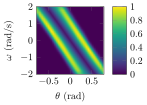

In [125]:
ax1 = Axis(Plots.Image((x, y) -> risk_weight([x, y], α=0), (-π / 4, π / 4), (-2, 2),
    colormap=pasteljet))
ax1.xlabel = L"$\theta$ (rad)"
ax1.ylabel = L"$\omega$ (rad/s)"
ax1.height = "4cm"
ax1.width = "4cm"
#PGFPlots.save("pend_risk_weights.tex", ax1, include_preamble=false)
ax1

In [127]:
maximum([risk_weight([x, y], α=0) for x in collect(0:0.1:π/4) for y in collect(0:0.1:2)])

0.43573721475690846